In [18]:
import os
import json
import pandas as pd
import sys
import torch
from transformers import BertTokenizer, BertModel

module_path = os.path.abspath(os.path.join('D:/julixus/MEISD/meisd_project/preprocessing.py'))
if module_path not in sys.path:
    sys.path.append(module_path)

import preprocessing

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [29]:
def load_data(file_path):
    with open(file_path, "r", encoding='utf-8') as file:
        data = json.load(file)
    return data

dataset = load_data("D:/julixus/MEISD/meisd_project/data/ESConv.json")

In [30]:
dataframe.head()

,experience_type,emotion_type,problem_type,situation,survey_score,dialog,seeker_question1,seeker_question2,supporter_question1,supporter_question2
0,Previous Experience,anxiety,job crisis,I hate my job but I am scared to quit and seek...,"{'seeker': {'initial_emotion_intensity': '5', ...","[{'speaker': 'seeker', 'annotation': {}, 'cont...",Partner was very supportive,More guidance in conversation or examples,,
1,Current Experience,anger,problems with friends,I have complete unsupportive friends its to th...,"{'seeker': {'initial_emotion_intensity': '5', ...","[{'speaker': 'supporter', 'annotation': {'stra...",,,It was simple,The middle screen hover function gets in the way
2,Current Experience,fear,job crisis,I have been out of work for five weeks in quar...,"{'seeker': {'initial_emotion_intensity': '4', ...","[{'speaker': 'supporter', 'annotation': {'stra...",no,no,,
3,Current Experience,depression,ongoing depression,I am depressed staying home due to COVID,"{'seeker': {'initial_emotion_intensity': '4', ...","[{'speaker': 'supporter', 'annotation': {'stra...",No,No,,
4,Current Experience,depression,breakup with partner,I found out that my boyfriend had been lying t...,"{'seeker': {'initial_emotion_intensity': '5', ...","[{'speaker': 'supporter', 'annotation': {'stra...",Good exercise,no,,


In [34]:
def extract_seeker_data(data, key):
    result = []

    for entry in data:
        dialog = entry['dialog']
        seeker_dialog = [item['content'].strip() for item in dialog if item['speaker'] == 'seeker']

        quarter_length = max(1, len(seeker_dialog) // 4)

        if key == 'initial_emotion_intensity':
            selected_dialog = seeker_dialog[:quarter_length]
        elif key == 'final_emotion_intensity':
            selected_dialog = seeker_dialog[-quarter_length:]
        else:
            continue

        result.append({
            key: entry['survey_score']['seeker'][key],
            'dialog': selected_dialog
        })

    return result

first_25_percent = extract_seeker_data(dataset, 'initial_emotion_intensity')
#last_25_percent = extract_seeker_data(dataset, 'final_emotion_intensity')

first_25_df = pd.DataFrame(first_25_percent)
#last_25_df = pd.DataFrame(last_25_percent)

first_25_df.head()

# with open('first_25_percent.json', 'w', encoding='utf-8') as file:
#     json.dump(first_25_percent, file, ensure_ascii=False, indent=4)
# 
# with open('last_25_percent.json', 'w', encoding='utf-8') as file:
#     json.dump(last_25_percent, file, ensure_ascii=False, indent=4)

#print("Zestawy danych zostały zapisane jako 'first_25_percent.json' i 'last_25_percent.json'.")

,initial_emotion_intensity,dialog
0,5,"[Hello, I am having a lot of anxiety about qui..."
1,5,"[hello im looking for someone to talk to, im f..."
2,4,"[Hello, I'm concerned about my job. I have bee..."
3,4,"[I am dong good. You?, I have been staying hom..."
4,5,"[Infinitely complicated., Too many decisions. ..."


In [35]:
MAX_LEN = 100
BATCH = 8
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
EPOCHS = 10
LEARNING_RATE = 1e-5
THRESHOLD = 0.2
DROPOUT_RATE = 0.3
WEIGHT_DECAY = 0.01
MODE = 'min'
PATIENCE = 2
FACTOR = 0.5
VERBOSE = True

In [36]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")

In [43]:
first_25_df['dialog']

0       [Hello, I am having a lot of anxiety about qui...
1       [hello im looking for someone to talk to, im f...
2       [Hello, I'm concerned about my job. I have bee...
3       [I am dong good. You?, I have been staying hom...
4       [Infinitely complicated., Too many decisions. ...
                              ...                        
1295    [I feel sleepy but can not sleep, It has alway...
1296    [I am fine. thanks. how about you ?, I lost my...
1297          [HI how are you today, Doing well, thanks.]
1298    [Hello, I am a little down today.  How are you...
1299                                    [hi, i'm nereida]
Name: dialog, Length: 1300, dtype: object

In [39]:
token_lens = []

for txt in first_25_df['dialog']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

In [46]:
min(token_lens)

3

C:\Users\Julix\AppData\Local\Temp\ipykernel_8440\2924673779.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

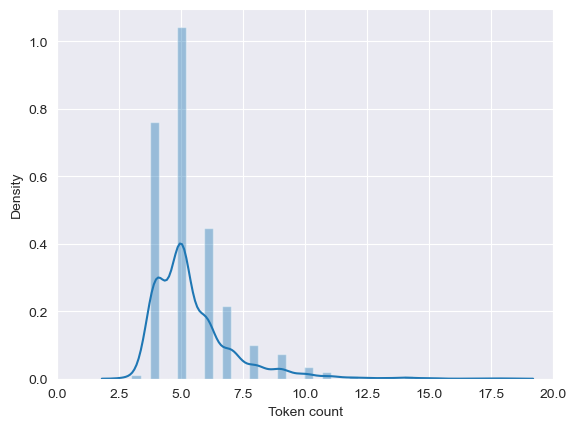

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(token_lens)
plt.xlim([0, 20])
plt.xlabel('Token count')